# Edward as visualized by Moana on May 8

### Important note
It takes <font color='red'>over 50 minutes</font> to run this notebook! Especially line [7]. There is no way around it, I confirmed it with NASA.

### Contents
1. Setup
2. Edward zoomed-out
3. Create dataset with lat long coordinates
4. Edward zoomed-in (NOT based on lat long coordinates)

# 1. Setup

In [1]:
# Import libraries and functions
import csv
import os

import cartopy.crs as ccrs
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

#### Note on function to help write OCSSW parameter files
To write the results in the format understood by OCSSW, this function uses the `csv.writer` from the Python Standard Library. Instead of writing comma-separated values, however, we specify a non-default delimiter to get equals-separated values. Not something you usually see in a data file, but it's better than
writing our own utility from scratch! Learn more under: #help(write_par)

In [2]:
# Define function to help write parameter files
def write_par(path, par):
    """
    Prepare a "par file" to be read by one of the OCSSW tools, as an
    alternative to specifying each parameter on the command line.

    Args:
        path (str): where to write the parameter file
        par (dict): the parameter names and values included in the file
    """
    with open(path, "w") as file:
        writer = csv.writer(file, delimiter="=")
        values = writer.writerows(par.items())

# 2. Edward zoomed-out

#### Note on l2bin:
It is very slow, takes <font color='red'>over 50 minutes</font> to run.
There is <font color='red'>no way to pre-define a boundary box upfront</font>: the entire region has to run and then we have to crop.

In [3]:
# Define Edward :)
tspan = ("2024-05-08", "2024-05-09")
location = (-70, 36) # We can not use Boundary box, as l2gen can not process that information

results = earthaccess.search_data(
    short_name="PACE_OCI_L1B_SCI",
    temporal=tspan,
    point=location,
)
results[0]

Granules found: 1


Collection: {'Version': '2', 'ShortName': 'PACE_OCI_L1B_SCI'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 43.50279, 'Longitude': -62.77217}, {'Latitude': 37.75396, 'Longitude': -93.93378}, {'Latitude': 20.44419, 'Longitude': -86.65385}, {'Latitude': 25.66325, 'Longitude': -61.02786}, {'Latitude': 43.50279, 'Longitude': -62.77217}]}}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2024-05-08T17:46:00Z', 'BeginningDateTime': '2024-05-08T17:41:00Z'}}
Size(MB): 1736.7857131958008
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240508T174100.L1B.V2.nc']

In [ ]:
# Define data path
paths = earthaccess.download(results, local_path="data")

In [ ]:
# Take a peek on the map (this does not yet contain any relevant info)
dataset = xr.open_dataset(paths[0], group="observation_data")
artist = dataset["rhot_red"].sel({"red_bands": 100}).plot()

In [14]:
# Defne parameters
ifile = paths[0]
par = {
    "ifile": ifile,
    "ofile": str(ifile).replace(".L1B.", ".L2_MOANA."),
    "suite": "BGC",
    "l2prod": "picoeuk_moana prococcus_moana syncoccus_moana rhos_465 rhos_555 rhos_645 poc chlor_a ",
    "atmocor": 1,
}
write_par("l2gen-moana.par", par)

This cell below runs Moana on the selected region, it takes <font color='red'>over 30 minutes</font> to run.

In [15]:
%%bash
source $OCSSWROOT/OCSSW_bash.env

l2gen par=l2gen-moana.par

Loading default parameters from /opt/ocssw/share/common/msl12_defaults.par
Input file data/PACE_OCI.20240508T174100.L1B.V2.nc is PACE L1B file.

Loading characteristics for OCI
Opening sensor information file /opt/ocssw/share/oci/msl12_sensor_info.dat
  Bnd   Lam       Fo    Tau_r     k_oz    k_no2    t_co2   awhite       aw      bbw
    0  314.550  112.026 4.873e-01 4.208e-01 3.281e-19 1.000e+00 0.000e+00 2.305e-01 6.356e-03
    1  316.239   92.478 6.485e-01 5.806e-01 2.961e-19 1.000e+00 0.000e+00 1.633e-01 7.727e-03
    2  318.262   85.195 7.410e-01 5.473e-01 2.844e-19 1.000e+00 0.000e+00 1.278e-01 8.187e-03
    3  320.303   82.175 7.809e-01 4.609e-01 2.833e-19 1.000e+00 0.000e+00 1.105e-01 8.271e-03
    4  322.433   80.733 7.906e-01 3.543e-01 2.898e-19 1.000e+00 0.000e+00 9.950e-02 8.190e-03
    5  324.649   86.251 7.915e-01 2.567e-01 3.018e-19 1.000e+00 0.000e+00 9.079e-02 8.041e-03
    6  326.828   95.932 7.891e-01 1.907e-01 3.132e-19 1.000e+00 0.000e+00 8.475e-02 7.871e-03
    7 

In [21]:
# Define dataset
dataset_geophysical = xr.open_dataset(par["ofile"], group="geophysical_data")

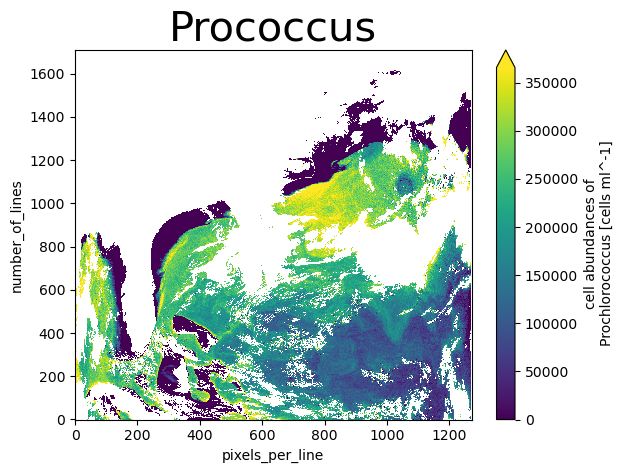

In [22]:
# Visualize data for prococcus_moana
artist = dataset_geophysical["prococcus_moana"].plot(cmap="viridis", robust=True)
plt.title("Prococcus", fontsize = 30)
plt.savefig('prococcus_zoomed_out.png')

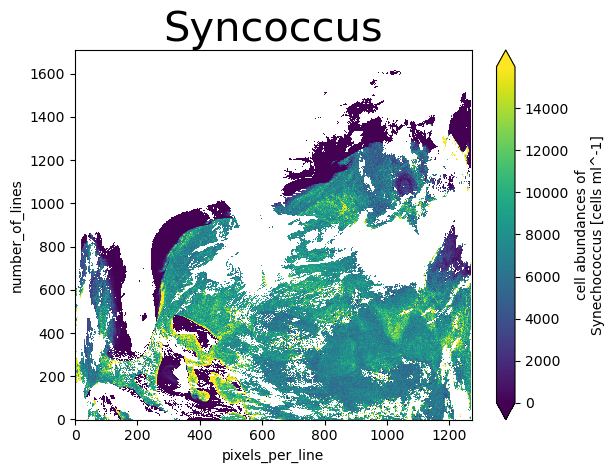

In [24]:
# Visualize data for syncoccus_moana
artist = dataset_geophysical["syncoccus_moana"].plot(cmap="viridis", robust=True)
plt.title("Syncoccus", fontsize = 30)
plt.savefig('syncoccus_zoomed_out.png')

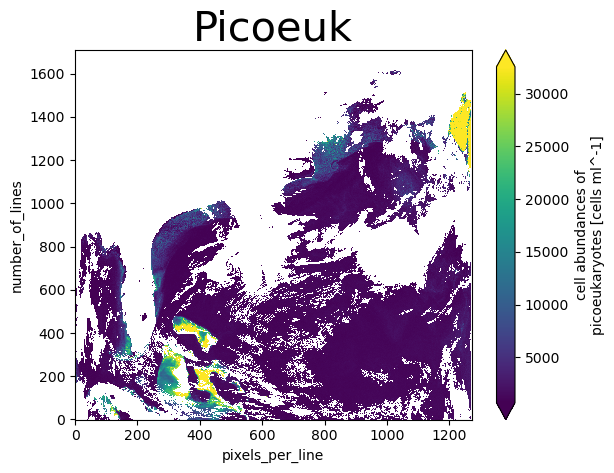

In [20]:
# Visualize data for picoeuk_moana
artist = dataset_geophysical["picoeuk_moana"].plot(cmap="viridis", robust=True)
plt.title("Picoeuk", fontsize = 30)
plt.savefig('picoeuk_zoomed_out.png')

### 3. Create dataset with lat long coordinates

In [25]:
# Create dataset with lat long coordinates
dataset_navigation = xr.open_dataset(par["ofile"], group="navigation_data")
dataset_merged = xr.merge((dataset, nav))
#dataset

In [26]:
# Download file as netCDF
dataset.to_netcdf('dataset_merged')

In [27]:
# Peek at file as netCDF
dataset

<xarray.Dataset> Size: 96MB
Dimensions:          (number_of_lines: 1710, pixels_per_line: 1272)
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    picoeuk_moana    (number_of_lines, pixels_per_line) float32 9MB ...
    prococcus_moana  (number_of_lines, pixels_per_line) float32 9MB ...
    syncoccus_moana  (number_of_lines, pixels_per_line) float32 9MB ...
    rhos_465         (number_of_lines, pixels_per_line) float32 9MB ...
    rhos_555         (number_of_lines, pixels_per_line) float32 9MB ...
    rhos_645         (number_of_lines, pixels_per_line) float32 9MB ...
    poc              (number_of_lines, pixels_per_line) float32 9MB ...
    chlor_a          (number_of_lines, pixels_per_line) float32 9MB ...
    l2_flags         (number_of_lines, pixels_per_line) int32 9MB ...
    longitude        (number_of_lines, pixels_per_line) float32 9MB -86.65 .....
    latitude         (number_of_lines, pixels_per_line) float32 9MB 20.44 ......
    tilt             (number_of_lines) float32 7kB 19.88 19.88 ... 19.88 19.88

### 4. Edward zoomed-in (NOT based on lat long coordinates)

In [28]:
# Define limits for zoom
x_min = 700
x_max = 900
y_min = 900
y_max = 1100

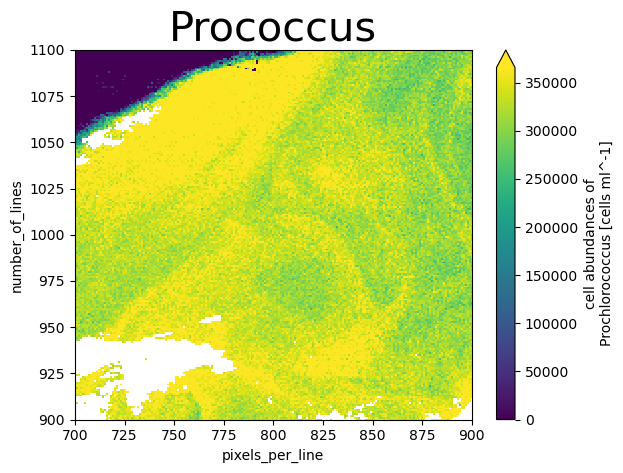

In [29]:
# Visualize data for prococcus_moana
artist = dataset["prococcus_moana"].plot(cmap="viridis", robust=True)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title("Prococcus", fontsize = 30)
plt.savefig('prococcus_zoomed_in.png')

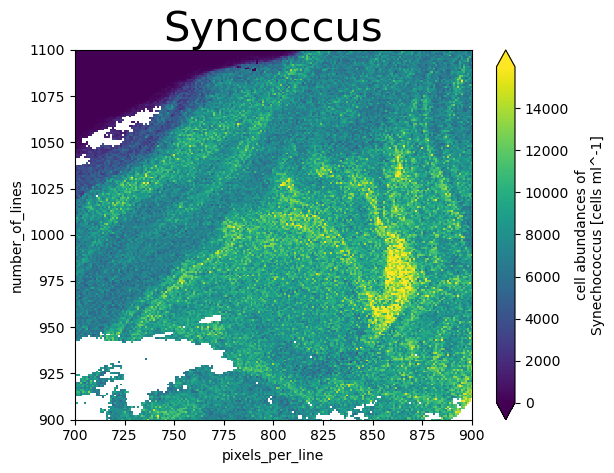

In [30]:
# Visualize data for syncoccus_moana
artist = dataset["syncoccus_moana"].plot(cmap="viridis", robust=True)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title("Syncoccus", fontsize = 30)
plt.savefig('syncoccus_zoomed_in.png')

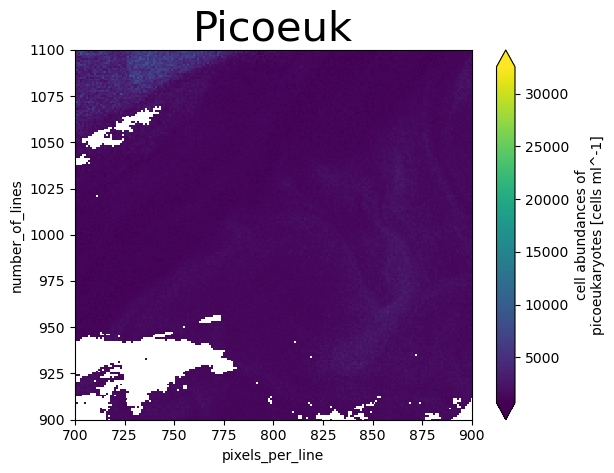

In [31]:
# Visualize data for picoeuk_moana
artist = dataset["picoeuk_moana"].plot(cmap="viridis", robust=True)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title("Picoeuk", fontsize = 30)
plt.savefig('picoeuk_zoomed_in.png')